***

# Exploratory Cluster Analysis

- By [Zachary Kilhoffer](https://zkilhoffer.github.io/)
- Updated 2024-06-17

***

## Description
- The code is part of the pipelines described in: 
  - Kilhoffer, Z. et al. (2024 in press). "Cloud Privacy Beyond Legal Compliance: An NLP analysis of certifiable privacy and security standards".
- The paper will be released on 2024-06-28 at the [IEEE Cloud Summit](https://www.ieeecloudsummit.org/2024-program).

***

- This script performs cluster analysis, an unsupervised machine learning technique, to place similar texts into groups.
- This was exploratory work with various types of cluster analysis.
- Ultimately we used [HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html "scikit-learn documentation for HDBSCAN"). 

***

### Input files:
 - ...
 - ...

### Output files:
- ....
- ...

***

In [ ]:
import os, re, warnings, random
import pandas as pd
import numpy as np
import torch
import openpyxl
from transformers import BertTokenizer, BertModel, pipeline

from bertopic import BERTopic
import nltk
from nltk.corpus import words
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
import ast

# Setup

In [ ]:
# display tweaks
pd.set_option("display.max_colwidth", 200)  # how much text is showing within a cell
pd.set_option("display.max_columns", False)
pd.set_option("display.max_rows", False)
warnings.filterwarnings("ignore")

In [ ]:
# load data
df = pd.read_excel('../data/df_embeddings_publicdomain.xlsx')

### Model choices

- You can experiment with the larger version of BERT if desired
    

```
# for BERT large - takes much longer to run
model_name = "bert-large-uncased"
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# make embeddings
df['BERTlargeembeddings'] = df['full_control_text'].apply(get_embedding)

```

* Many of the best models can't be run locally, so they require API calls. 
* You can do something like this:

```
# reads key.txt in the current directory
def read_key_from_file(filename=r"key.txt"):  # replace with yours
    with open(filename, 'r') as file:
        return file.read().strip()

# setup client for OpenAI with your API key and organization

org = 'YOUR_ORG_HERE' 
client = OpenAI(organization='YOUR_ORG_HERE', 
                api_key=read_key_from_file()
                )
    
# creates embeddings with short text to see if the setup worked properly
response = client.embeddings.create(
    input="Was mich nicht umbringt",
    model="text-embedding-ada-002"
)

# show result
print(response.data[0].embedding)

```

# K-means

In [ ]:
df['len_temp'] = df['ada2_embeddings'].apply(lambda x: len(x))
df['len_temp'].value_counts()

In [ ]:
## Elbow plots

In [1]:
# Function to compute and plot WCSS for different number of clusters
def plot_elbow_method(embeddings, title):
    wcss = []
    for i in range(1, 100):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init='auto', random_state=0)
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, 100), wcss)
    plt.title(f'Elbow Plot for {title}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

In [ ]:
# Convert embeddings lists to numpy arrays for KMeans
ada2_embeddings_np = np.array(df['ada2_embeddings'].tolist())

# Plotting Elbow Method for each embeddings
plot_elbow_method(ada2_embeddings_np, 'ADA2 Embeddings')

In [ ]:
# Convert embeddings lists to numpy arrays for KMeans
bert_embeddings_np = np.array(df['BERTembeddings'].tolist())

# Plotting Elbow Method for each embeddings
plot_elbow_method(bert_embeddings_np, 'BERT Embeddings')

# Davies-Bouldin index

In [ ]:
# Function to compute and plot Davies-Bouldin Index for different number of clusters
def plot_davies_bouldin_index(embeddings, title):
    dbi = []
    for i in range(2, 100):  # Davies-Bouldin can't be computed for less than 2 clusters
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        cluster_labels = kmeans.fit_predict(embeddings)
        db_index = davies_bouldin_score(embeddings, cluster_labels)
        dbi.append(db_index)

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 100), dbi, marker='o')
    plt.title(f'Davies-Bouldin Index for {title}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Davies-Bouldin Index')
    plt.grid(True)
    plt.show()

In [ ]:
# Convert the lists of embeddings to a 2D numpy array
ada2_embeddings = np.array(df['ada2_embeddings'].tolist())
plot_davies_bouldin_index(ada2_embeddings, 'ada-2 Embeddings')

In [ ]:
# Convert the lists of embeddings to a 2D numpy array
bert_embeddings = np.array(df['BERTembeddings'].tolist())
plot_davies_bouldin_index(bert_embeddings, 'BERT Embeddings')

# Dimensionality reduction

In [ ]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
standard_embedding = umap.UMAP(random_state=69).fit_transform(bert_embeddings)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral')
plt.title(f'UMAP reduction for BERT')

In [ ]:
# Convert the lists of embeddings to a 2D numpy array
standard_embedding = umap.UMAP(random_state=69).fit_transform(bert_embeddings)
# bert_embeddings = np.array(df['BERTembeddings'].tolist())
plot_davies_bouldin_index(standard_embedding, 'BERT Embeddings reduced')

In [ ]:
# Convert the lists of embeddings to a 2D numpy array
standard_embedding = umap.UMAP(random_state=69).fit_transform(ada2_embeddings)
# bert_embeddings = np.array(df['BERTembeddings'].tolist())
plot_davies_bouldin_index(standard_embedding, 'ada2 Embeddings reduced')

In [ ]:
plot_elbow_method(standard_embedding, 'UMAP BERT Embeddings')

In [ ]:
# Function to compute and plot WCSS for different number of clusters
def plot_elbow_method(embeddings, title):
    wcss = []
    for i in range(1, 100):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init='auto', random_state=0)
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, 100), wcss)
    plt.title(f'Elbow Plot for {title}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.axvline(x=6, color='red', linewidth=1)
    plt.show()

standard_embedding = umap.UMAP(random_state=69).fit_transform(bert_embeddings)
plot_elbow_method(standard_embedding, 'UMAP BERT Embeddings')

In [ ]:
standard_embedding = umap.UMAP(random_state=69).fit_transform(ada2_embeddings)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral')
plt.title(f'UMAP reduction for ada-2')

In [ ]:
# Function to compute and plot WCSS for different number of clusters
def plot_elbow_method(embeddings, title):
    wcss = []
    for i in range(1, 100):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init='auto', random_state=0)
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, 100), wcss)
    plt.title(f'Elbow Plot for {title}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.axvline(x=9, color='red', linewidth=1)
    plt.show()

plot_elbow_method(standard_embedding, 'UMAP ada-2 Embeddings')

In [ ]:
standard_embedding = umap.UMAP(random_state=69).fit_transform(ada2_embeddings)
kmeans_labels = cluster.KMeans(n_clusters=9).fit_predict(standard_embedding)

In [ ]:
standard_embedding = umap.UMAP(random_state=69).fit_transform(bert_embeddings)
kmeans_labels = cluster.KMeans(n_clusters=6).fit_predict(standard_embedding)

# Silhouette Scores

In [ ]:
from sklearn.metrics import silhouette_score

def plot_silhouette_scores(embeddings, max_range):
    silhouette_scores = []
    
    # Start from 2 clusters because silhouette score cannot be calculated for a single cluster
    for i in range(2, max_range + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f'Number of clusters: {i}, Silhouette Score: {silhouette_avg:.3f}')
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_range + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

Number of clusters: 2, Silhouette Score: 0.573
Number of clusters: 3, Silhouette Score: 0.524
Number of clusters: 4, Silhouette Score: 0.487
Number of clusters: 5, Silhouette Score: 0.443
Number of clusters: 6, Silhouette Score: 0.420
Number of clusters: 7, Silhouette Score: 0.365
Number of clusters: 8, Silhouette Score: 0.369
Number of clusters: 9, Silhouette Score: 0.363
Number of clusters: 10, Silhouette Score: 0.358
Number of clusters: 11, Silhouette Score: 0.321
Number of clusters: 12, Silhouette Score: 0.313
Number of clusters: 13, Silhouette Score: 0.307
Number of clusters: 14, Silhouette Score: 0.310
Number of clusters: 15, Silhouette Score: 0.266
Number of clusters: 16, Silhouette Score: 0.284
Number of clusters: 17, Silhouette Score: 0.277
Number of clusters: 18, Silhouette Score: 0.287
Number of clusters: 19, Silhouette Score: 0.269
Number of clusters: 20, Silhouette Score: 0.241
Number of clusters: 21, Silhouette Score: 0.242
Number of clusters: 22, Silhouette Score: 0.271


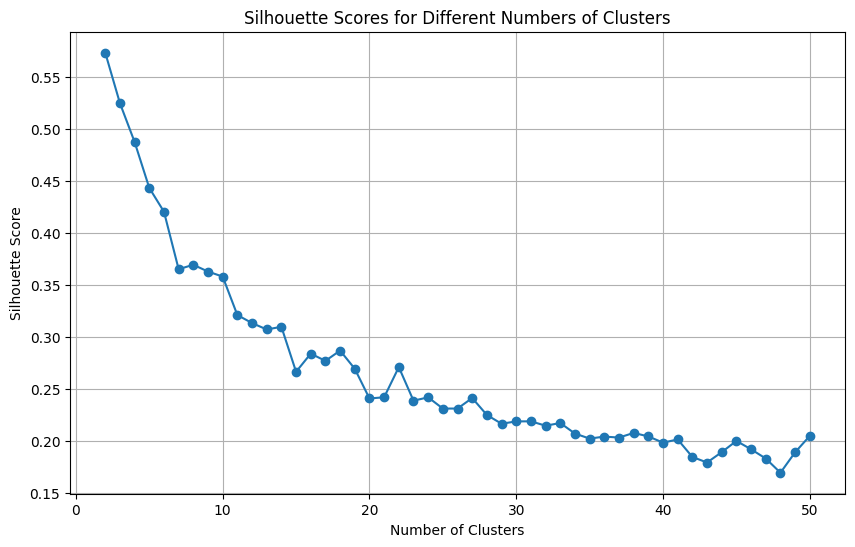

In [ ]:
# BERT Silhouette
plot_silhouette_scores(bert_embeddings, 50)

Number of clusters: 2, Silhouette Score: 0.562
Number of clusters: 3, Silhouette Score: 0.561
Number of clusters: 4, Silhouette Score: 0.538
Number of clusters: 5, Silhouette Score: 0.532
Number of clusters: 6, Silhouette Score: 0.529
Number of clusters: 7, Silhouette Score: 0.510
Number of clusters: 8, Silhouette Score: 0.504
Number of clusters: 9, Silhouette Score: 0.493
Number of clusters: 10, Silhouette Score: 0.491
Number of clusters: 11, Silhouette Score: 0.490
Number of clusters: 12, Silhouette Score: 0.479
Number of clusters: 13, Silhouette Score: 0.466
Number of clusters: 14, Silhouette Score: 0.453
Number of clusters: 15, Silhouette Score: 0.439
Number of clusters: 16, Silhouette Score: 0.437
Number of clusters: 17, Silhouette Score: 0.430
Number of clusters: 18, Silhouette Score: 0.434
Number of clusters: 19, Silhouette Score: 0.437
Number of clusters: 20, Silhouette Score: 0.429
Number of clusters: 21, Silhouette Score: 0.437
Number of clusters: 22, Silhouette Score: 0.430


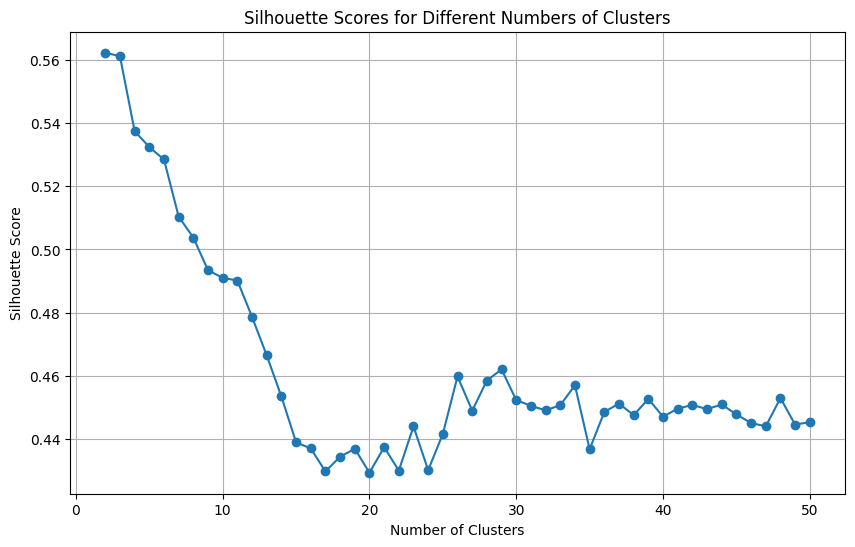

In [ ]:
# after reducing dimensionality
standard_embedding = umap.UMAP(random_state=69).fit_transform(bert_embeddings)
plot_silhouette_scores(standard_embedding, 50)

Number of clusters: 2, Silhouette Score: 0.060
Number of clusters: 3, Silhouette Score: 0.054
Number of clusters: 4, Silhouette Score: 0.060
Number of clusters: 5, Silhouette Score: 0.050
Number of clusters: 6, Silhouette Score: 0.056
Number of clusters: 7, Silhouette Score: 0.055
Number of clusters: 8, Silhouette Score: 0.059
Number of clusters: 9, Silhouette Score: 0.065
Number of clusters: 10, Silhouette Score: 0.064
Number of clusters: 11, Silhouette Score: 0.071
Number of clusters: 12, Silhouette Score: 0.067
Number of clusters: 13, Silhouette Score: 0.077
Number of clusters: 14, Silhouette Score: 0.074
Number of clusters: 15, Silhouette Score: 0.079
Number of clusters: 16, Silhouette Score: 0.064
Number of clusters: 17, Silhouette Score: 0.075
Number of clusters: 18, Silhouette Score: 0.077
Number of clusters: 19, Silhouette Score: 0.080
Number of clusters: 20, Silhouette Score: 0.081
Number of clusters: 21, Silhouette Score: 0.085
Number of clusters: 22, Silhouette Score: 0.075


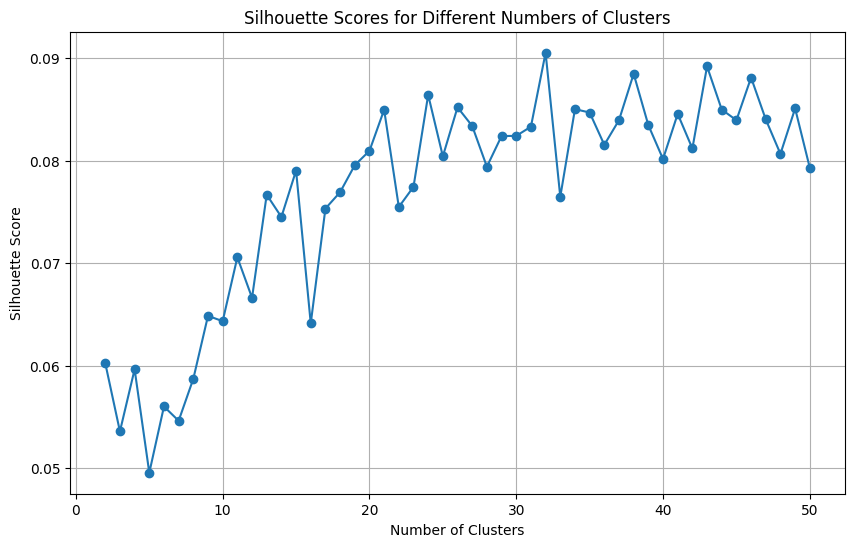

In [ ]:
# ada-2 Silhouette
plot_silhouette_scores(ada2_embeddings, 50)

Number of clusters: 2, Silhouette Score: 0.508
Number of clusters: 3, Silhouette Score: 0.498
Number of clusters: 4, Silhouette Score: 0.469
Number of clusters: 5, Silhouette Score: 0.493
Number of clusters: 6, Silhouette Score: 0.456
Number of clusters: 7, Silhouette Score: 0.483
Number of clusters: 8, Silhouette Score: 0.524
Number of clusters: 9, Silhouette Score: 0.528
Number of clusters: 10, Silhouette Score: 0.521
Number of clusters: 11, Silhouette Score: 0.535
Number of clusters: 12, Silhouette Score: 0.530
Number of clusters: 13, Silhouette Score: 0.527
Number of clusters: 14, Silhouette Score: 0.538
Number of clusters: 15, Silhouette Score: 0.514
Number of clusters: 16, Silhouette Score: 0.524
Number of clusters: 17, Silhouette Score: 0.536
Number of clusters: 18, Silhouette Score: 0.544
Number of clusters: 19, Silhouette Score: 0.529
Number of clusters: 20, Silhouette Score: 0.561
Number of clusters: 21, Silhouette Score: 0.562
Number of clusters: 22, Silhouette Score: 0.569


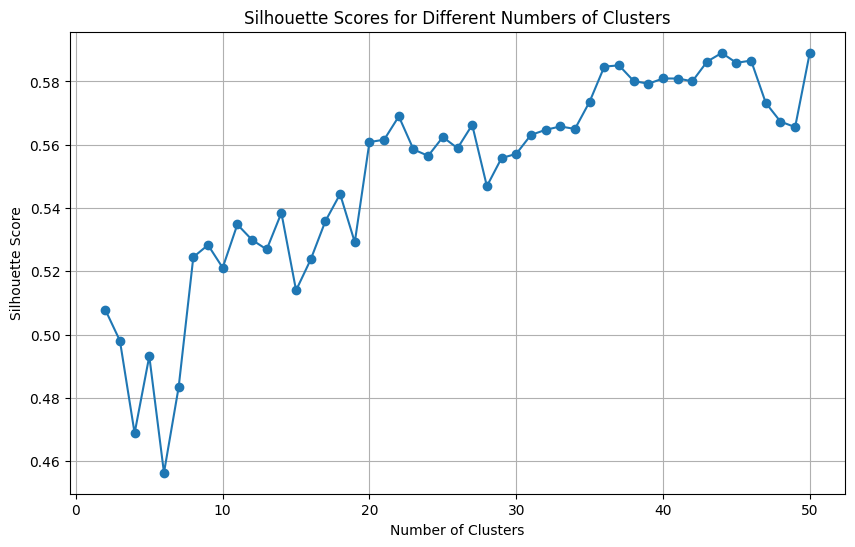

In [ ]:
# after reducing dimensionality
standard_embedding = umap.UMAP(random_state=69).fit_transform(ada2_embeddings)
plot_silhouette_scores(standard_embedding, 50)